In [26]:
import segmentation_models_pytorch as smp
import vaex as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from scripts.config import Config
from scripts.utils import CellDataset, im_convert
from scripts.train import train
# %matplotlib inline

config = Config()
sns.set() 

In [2]:
df_train = pd.read_csv(config.TRAIN_CSV)

In [3]:
df_train.head()

#,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,'118145 6 118849 7 119553 8 120257 8 120961 9 12...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,'189036 1 189739 3 190441 6 191144 7 191848 8 19...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,'173567 3 174270 5 174974 5 175678 6 176382 7 17...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,'196723 4 197427 6 198130 7 198834 8 199538 8 20...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,'167818 3 168522 5 169225 7 169928 8 170632 9 17...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
5,0030fd0e6378,'205984 2 206687 4 207391 5 208095 5 208799 6 20...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
6,0030fd0e6378,'203101 2 203805 5 204509 7 205213 10 205917 12 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
7,0030fd0e6378,'191900 2 192604 3 193308 4 194012 5 194717 5 19...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
8,0030fd0e6378,'184848 3 185551 5 186254 7 186958 8 187662 9 18...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
9,0030fd0e6378,'165119 1 165822 4 166526 6 167230 9 167935 9 16...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [4]:
df_train.info()

In [5]:
vc = df_train["cell_type"].value_counts()

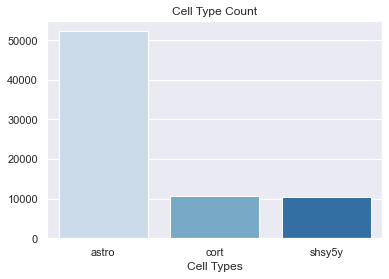

In [6]:
sns.barplot(x=df_train["cell_type"].unique(), y=vc, palette="Blues")
plt.title("Cell Type Count")
plt.xlabel("Cell Types")
plt.show()

In [7]:
ds_train = CellDataset(df_train)

In [8]:
dl_train = DataLoader(
    ds_train, 
    batch_size=config.BATCH_SIZE, 
    num_workers=4, 
    pin_memory=True, 
    shuffle=False
)

In [17]:
def display_dataset(dl):
    """
    Displays the dataset. Useful for making sure your data was loaded properly.
    """      
    
    dataiter = iter(dl)
    images, labels = dataiter.next()
    fig = plt.figure(figsize=(25, 8))

    for idx in np.arange(min(config.BATCH_SIZE, 20)):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(im_convert(images[idx], mean=config.MEAN, std=config.STD))
        # plt.show()
        plt.imshow(im_convert(labels[idx], mean=(0, 0, 0), std=(1, 1, 1)), alpha=0.3)
        plt.show();
        # ax.set_title(train_utils.classes[labels[idx].numpy()])

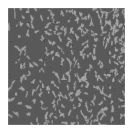

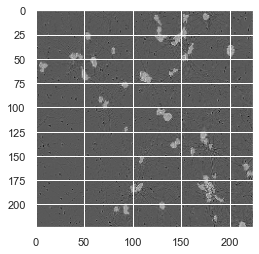

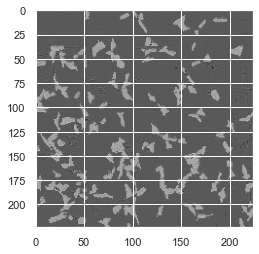

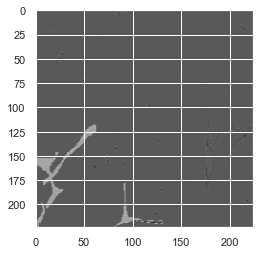

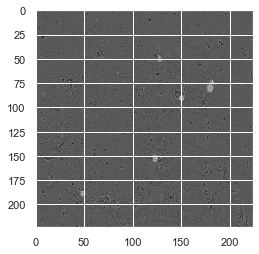

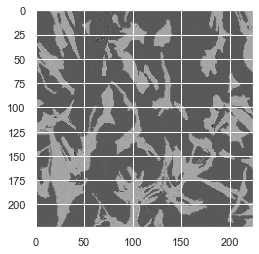

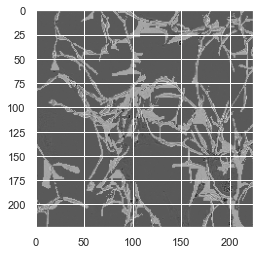

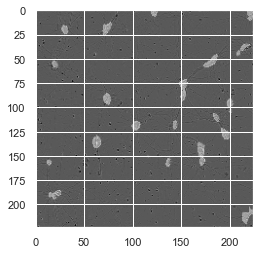

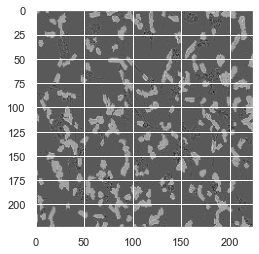

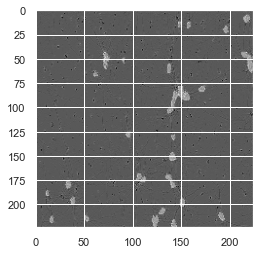

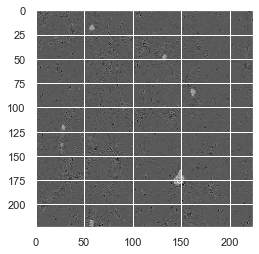

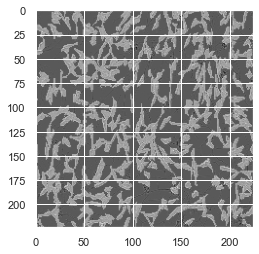

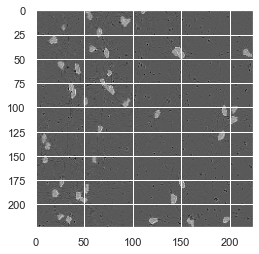

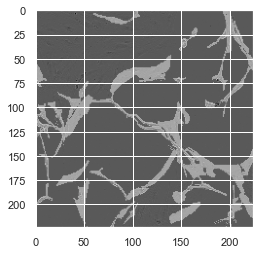

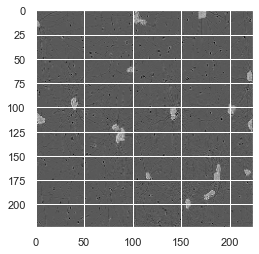

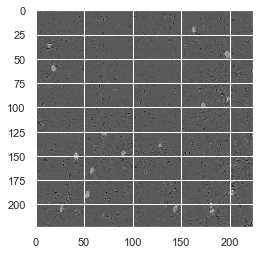

In [18]:
display_dataset(dl=dl_train)

In [20]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.4MB/s]


In [24]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [25]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [30]:
criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
args = {"criterion": criterion,
        "optimizer": optimizer}

In [31]:
# train(model, config, dl_train, True, args)

TypeError: train() takes from 3 to 4 positional arguments but 5 were given